In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter('ignore')

d:\programfile\python3.7.4\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
d:\programfile\python3.7.4\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
d:\programfile\python3.7.4\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
d:\programfile\python3.7.4\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarnin

In [2]:
np.random.seed(1234)
tf.set_random_seed(1234)

In [3]:
class DeepONet():
    def __init__(self, X, y, branch_layer, trunk_layer, y_d):
        self.y_d = y_d
        self.Um = X[:, :-y_d]
        self.y =  X[:, -y_d:]
        self.Guy_true = y

        self.branch_layer = branch_layer
        self.trunk_layer  = trunk_layer

        self.sess = tf.Session()
        self.branch_weights, self.branch_biases = self.initilize_NN(branch_layer)
        self.trunk_weights, self.trunk_biases = self.initilize_NN(trunk_layer)
        self.bias = tf.Variable(tf.zeros([1], dtype=tf.float32), dtype=tf.float32)

        self.x_tf = tf.placeholder(tf.float32, shape=[None, self.Um.shape[1]])
        self.y_tf = tf.placeholder(tf.float32, shape=[None, self.y.shape[1]])

        self.branch_out = self.neural_net(self.x_tf, self.branch_weights, self.branch_biases)
        self.trunk_out  = self.neural_net(self.y_tf, self.trunk_weights, self.trunk_biases)
        self.Guy_pred = tf.reshape(tf.reduce_sum(tf.multiply(self.branch_out, self.trunk_out), axis=1) + self.bias, [-1, 1])

        self.loss = tf.reduce_mean(tf.square(self.Guy_pred - self.Guy_true))
        # self.loss = tf.sqrt(tf.reduce_sum(tf.square(self.Guy_pred - self.Guy_true)))
        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss,
                                                                method = 'L-BFGS-B',
                                                                options = {'maxiter': 50000,
                                                                           'maxfun': 50000,
                                                                           'maxcor': 50,
                                                                           'maxls': 50,
                                                                           'ftol' : 1.0 * np.finfo(float).eps})
        init = tf.global_variables_initializer()
        self.sess.run(init)

    def callback(self, Guy_pred, loss):
        print('Loss:', loss)
        print('Guy_pred:', Guy_pred)

    def initilize_NN(self, layers):
        weights = []
        biases  = []
        num_layers = len(layers)
        for l in range(0, num_layers - 1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)
        return weights, biases

    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)

    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1
        H = X
        for l in range(0, num_layers - 2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y

    def train(self):
        tf_dict = {
            self.x_tf : self.Um,
            self.y_tf : self.y
        }
        self.optimizer.minimize(
                self.sess,
                feed_dict = tf_dict,
                fetches = [self.Guy_pred, self.loss],
                loss_callback = self.callback
        )

    def predict(self, X_test):
        Guy_test = self.sess.run(self.Guy_pred, {self.x_tf: X_test[:, :-self.y_d], self.y_tf:X_test[:, -self.y_d:]})
        return Guy_test

In [4]:
# 尝试复现 积分算子
sensors = 100
random_y = 100
y_d = 1
s0      = 0   # initial
p       = 10
branch_layer = [sensors, 40, 40, p]
trunk_layer  = [y_d, 40, 40, 40, p]

In [5]:
x_train = np.load("./dataset/AntiInte/x_train.npy")
x_test  = np.load("./dataset/AntiInte/x_test.npy")
y_train = np.load("./dataset/AntiInte/y_train.npy")
y_test  = np.load("./dataset/AntiInte/y_test.npy")

In [6]:
model = DeepONet(x_train, y_train, branch_layer, trunk_layer, y_d)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [7]:
start_time = time.time()
model.train()
elapsed = time.time() - start_time
print('Training time: %.4f' % (elapsed))

Loss: 0.15105578
Guy_pred.shape: (1000, 1)
Loss: 1.3186969
Guy_pred.shape: (1000, 1)
Loss: 0.037233364
Guy_pred.shape: (1000, 1)
Loss: 0.031829637
Guy_pred.shape: (1000, 1)
Loss: 0.027718404
Guy_pred.shape: (1000, 1)
Loss: 0.025995253
Guy_pred.shape: (1000, 1)
Loss: 0.023758633
Guy_pred.shape: (1000, 1)
Loss: 0.020293564
Guy_pred.shape: (1000, 1)
Loss: 0.019683016
Guy_pred.shape: (1000, 1)
Loss: 0.01805642
Guy_pred.shape: (1000, 1)
Loss: 0.01748299
Guy_pred.shape: (1000, 1)
Loss: 0.017047608
Guy_pred.shape: (1000, 1)
Loss: 0.016290557
Guy_pred.shape: (1000, 1)
Loss: 0.014914932
Guy_pred.shape: (1000, 1)
Loss: 0.014145949
Guy_pred.shape: (1000, 1)
Loss: 0.013514642
Guy_pred.shape: (1000, 1)
Loss: 0.01332076
Guy_pred.shape: (1000, 1)
Loss: 0.013028326
Guy_pred.shape: (1000, 1)
Loss: 0.01268575
Guy_pred.shape: (1000, 1)
Loss: 0.011911765
Guy_pred.shape: (1000, 1)
Loss: 0.01149758
Guy_pred.shape: (1000, 1)
Loss: 0.0113581335
Guy_pred.shape: (1000, 1)
Loss: 0.011238662
Guy_pred.shape: (1000

In [8]:
y_pred = model.predict(x_test)

In [9]:
def plot(sensors, net):
    x = np.linspace(0, 1, num=sensors)
    y = np.linspace(0, 1, num=sensors)
    cos = np.cos(2 * np.pi * x)
    antide_true = np.sin(2 * np.pi * y) / (2 * np.pi)
    antide_pred = net.predict(np.hstack([np.tile(cos, (len(y), 1)), y[:, None]])).squeeze()

    plt.plot(x, cos, color='black', label=r'Input: $\cos(2\pi x)$', zorder=0)
    plt.plot(y, antide_true, color='b', label=r'Output: $\sin(2\pi x)/(2\pi)$', zorder=1)
    plt.plot(y, antide_pred, color='r', label=r'Prediction', zorder=2)
    plt.legend()
    plt.savefig('deeponet.pdf')

In [14]:
def plot(sensors, net):
    x = np.linspace(0, 1, num=sensors)
    y = np.linspace(0, 1, num=sensors)
    line = x + 1 + np.sin(x)
    antide_true = 1 / 2 * y**2 + y - np.cos(y) + 1
    antide_pred = net.predict(np.hstack([np.tile(line, (len(y), 1)), y[:, None]])).squeeze()
    plt.plot(x, line, color='black', label=r'Input', zorder=0)
    plt.plot(y, antide_true, color='b', label=r'Output', zorder=1)
    plt.plot(y, antide_pred, color='r', label=r'Prediction', zorder=2)
    plt.legend()
    plt.savefig('deeponet.pdf')


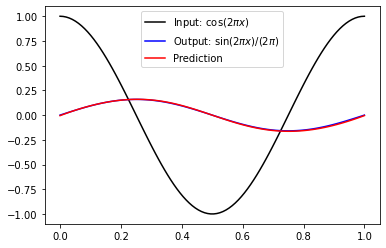

In [10]:
plot(sensors, model)

In [11]:
np.sqrt(np.sum(np.square(y_test - y_pred)))

0.3968741130831907

In [44]:
x = np.linspace(0, 1, sensors)
u_list = [lambda x:np.cos(x), lambda x:x, lambda x:np.exp(x)]
s_list = [lambda y:np.sin(y), lambda y:1/2*y**2, lambda y:np.exp(y) - 1]
Guy_ = []
input_y = []
for i in range(len(s_list)):
    y = np.random.rand(random_y, 1)
    input_y.append(y)
    Guy_.append(s_list[i](y))
y_train = np.array(Guy_).reshape(-1, 1)
input_u = []
for i in range(len(u_list)):
    input_u.append(np.hstack([np.tile(u_list[i](x), (sensors, 1)), input_y[i]]))
x_train = np.array(input_u).reshape(-1, sensors+y_d)

In [45]:
deepOnet = DeepONet(x_train, y_train, branch_layer, trunk_layer, y_d)

In [46]:
deepOnet.train()

Loss: 0.23407361
Guy_pred.shape: (300, 1)
Loss: 9.965235
Guy_pred.shape: (300, 1)
Loss: 0.049952973
Guy_pred.shape: (300, 1)
Loss: 0.042798553
Guy_pred.shape: (300, 1)
Loss: 0.03648373
Guy_pred.shape: (300, 1)
Loss: 0.029388567
Guy_pred.shape: (300, 1)
Loss: 0.015067737
Guy_pred.shape: (300, 1)
Loss: 0.007892058
Guy_pred.shape: (300, 1)
Loss: 0.0059618745
Guy_pred.shape: (300, 1)
Loss: 0.005217629
Guy_pred.shape: (300, 1)
Loss: 0.0043810997
Guy_pred.shape: (300, 1)
Loss: 0.0038913235
Guy_pred.shape: (300, 1)
Loss: 0.0036411146
Guy_pred.shape: (300, 1)
Loss: 0.0035236164
Guy_pred.shape: (300, 1)
Loss: 0.0034795809
Guy_pred.shape: (300, 1)
Loss: 0.00337642
Guy_pred.shape: (300, 1)
Loss: 0.0031803206
Guy_pred.shape: (300, 1)
Loss: 0.0028972337
Guy_pred.shape: (300, 1)
Loss: 0.0026163238
Guy_pred.shape: (300, 1)
Loss: 0.0029090312
Guy_pred.shape: (300, 1)
Loss: 0.0025426948
Guy_pred.shape: (300, 1)
Loss: 0.0024941082
Guy_pred.shape: (300, 1)
Loss: 0.0024691797
Guy_pred.shape: (300, 1)
Loss

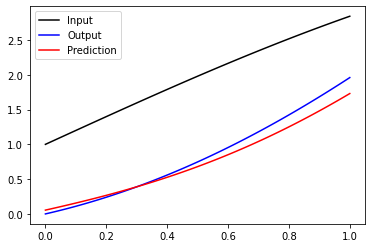

In [47]:
plot(sensors, deepOnet)

In [1]:
#求解Burgers方程

import scipy.io
data = scipy.io.loadmat('./dataset/Burgers/burgers_shock.mat')
x = data['x'].flatten()[:, None]
t = data['t'].flatten()[:, None]
Exact =np.real(data['usol']).T

NameError: name 'np' is not defined

In [18]:
X, T = np.meshgrid(x, t)
X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))
u_star = Exact.flatten()[:, None]
# 初始点
xx1 = np.hstack((X[0:1,:].T, T[0:1,:].T))
uu1 = Exact[0:1,:].T

In [19]:
# t = 0.25
xx25 = np.hstack((X[25:26, :].T, T[25:26, :].T))
uu25 = Exact[25:26, :].T
# t = 0.50
xx50 = np.hstack((X[50:51, :].T, T[50:51, :].T))
uu50 = Exact[50:51, :].T
# t = 0.75
xx75 = np.hstack((X[75:76, :].T, T[75:76, :].T))
uu75 = Exact[75:76, :].T

In [46]:
sensors  = 256
y_d      = 2
random_y = 200
p        = 10
branch_layer = [sensors, 256, 256, 256, p]
trunk_layer  = [y_d, 40, 40, 40, 40, p]

In [21]:
U_list = [uu1, uu1, uu1]
Exact_list = [uu25, uu50, uu75]
X_list = [xx25, xx50, xx75]
Guy_ = []
input_y = []
for i in range(len(Exact_list)):
    idx = np.random.choice(X_list[i].shape[0], random_y, replace=False)
    y = X_list[i][idx]
    input_y.append(y)
    Guy_.append(Exact_list[i][idx])
y_train = np.array(Guy_).reshape(-1, 1)

In [22]:
input_u = []
for i in range(len(U_list)):
    input_u.append(np.hstack([np.tile(U_list[i].reshape(1, -1), (random_y, 1)), input_y[i]]))
x_train = np.array(input_u).reshape(-1, sensors+y_d)

In [47]:
deepONet = DeepONet(x_train, y_train, branch_layer, trunk_layer, y_d)

In [50]:
deepONet.train()

MemoryError: 

In [38]:
y_pred = deepONet.predict(x_train)

In [39]:
np.sqrt(np.sum(np.square(y_train - y_pred)))

0.04344802816785857

In [28]:
# t = 0.4
xx40 = np.hstack((X[40:41, :].T, T[40:41, :].T))
uu40 = Exact[40:41, :].T
idx = np.random.choice(xx40.shape[0], random_y, replace=False)
y = xx40[idx]
y_test = uu40[idx]
x_test = np.hstack([np.tile(uu1.reshape(1, -1), (random_y, 1)), y])

In [40]:
y_pred = deepONet.predict(x_test)

In [41]:
np.sqrt(np.sum(np.square(y_test - y_pred)))

0.3306334418551083

In [33]:
def get_burgers(t, X, T, Exact, random_y, uu1, net):
    xx = np.hstack((X[t:t+1, :].T, T[t:t+1, :].T))
    uu = Exact[t:t+1, :].T
    idx = np.random.choice(xx.shape[0], random_y, replace=False)
    y = xx[idx]
    y_test = uu[idx]
    x_test = np.hstack([np.tile(uu1.reshape(1, -1), (random_y, 1)), y])
    y_pred = net.predict(x_test)
    return np.sqrt(np.sum(np.square(y_pred - y_test)))

In [42]:
get_burgers(90, X, T, Exact, random_y, uu1, deepONet)

0.44182727285283996